In [151]:
import typing as t
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from torch.utils.data import Dataset, DataLoader

In [152]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [153]:
DATA_DIR = Path("../data/")

CUDA = "cuda"
CPU = "cpu"
DEVICE = CUDA if torch.cuda.is_available() else CPU
print(f"Using {DEVICE.upper()} device")

Using CUDA device


## Предобработка данных и подготовка датасета

In [154]:
def na_stat(df: pd.DataFrame) -> pd.Series:
    stat = df.isna().sum()
    return stat[stat > 0]


def duplicates_stat(df: pd.DataFrame) -> pd.Series:
    return df[df.duplicated()].value_counts()


def get_categorical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(object).columns


def get_numerical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(np.number).columns


def count_categories(df: pd.DataFrame) -> pd.Series:
    return df[get_categorical_columns(df)].nunique()

In [155]:
vehicle_df: pd.DataFrame = pd.read_csv(DATA_DIR / "regression/vehicle.csv")
print(vehicle_df.shape)
vehicle_df.head()

(8128, 13)


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [156]:
na_stat(vehicle_df)

mileage      221
engine       221
max_power    215
torque       222
seats        221
dtype: int64

In [157]:
vehicle_df = vehicle_df.dropna()
na_stat(vehicle_df)

Series([], dtype: int64)

In [158]:
vehicle_df = vehicle_df.drop(columns=["name", "mileage", "torque"])
vehicle_df["max_power"] = vehicle_df["max_power"].str.replace(" bhp", "").astype(float)

In [159]:
duplicates_stat(vehicle_df)

year  selling_price  km_driven  fuel    seller_type       transmission  owner         engine   max_power  seats
2017  3200000        45000      Diesel  Dealer            Automatic     First Owner   1999 CC  177.00     5.0      33
2019  5150000        20000      Petrol  Dealer            Automatic     First Owner   2487 CC  214.56     5.0      33
2016  2000000        68089      Petrol  Trustmark Dealer  Automatic     First Owner   2494 CC  157.70     5.0      31
      550000         56494      Petrol  Trustmark Dealer  Manual        First Owner   1199 CC  88.70      5.0      31
2013  750000         79328      Diesel  Trustmark Dealer  Manual        Second Owner  2494 CC  100.60     7.0      30
                                                                                                                   ..
2015  245000         40000      Petrol  Individual        Manual        First Owner   796 CC   47.30      5.0       1
      250000         80000      Diesel  Individual        Manu

In [160]:
vehicle_df = vehicle_df.drop_duplicates()
duplicates_stat(vehicle_df)

Series([], dtype: int64)

In [161]:
count_categories(vehicle_df)

fuel              4
seller_type       3
transmission      2
owner             5
engine          121
dtype: int64

In [162]:
print(vehicle_df.shape)
vehicle_df.head()

(6690, 10)


,year,selling_price,km_driven,fuel,seller_type,transmission,owner,engine,max_power,seats
0,2014,450000,145500,Diesel,Individual,Manual,First Owner,1248 CC,74.00,5.0
1,2014,370000,120000,Diesel,Individual,Manual,Second Owner,1498 CC,103.52,5.0
2,2006,158000,140000,Petrol,Individual,Manual,Third Owner,1497 CC,78.00,5.0
3,2010,225000,127000,Diesel,Individual,Manual,First Owner,1396 CC,90.00,5.0
4,2007,130000,120000,Petrol,Individual,Manual,First Owner,1298 CC,88.20,5.0


In [163]:
class VehicleDataset(Dataset):
    encoder: OrdinalEncoder
    scaler: StandardScaler
    n_features: int
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, encoder: OrdinalEncoder = None, scaler: StandardScaler = None):
        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            encode = self.encoder.fit_transform

        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        target_col = "selling_price"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        encode_cols, scale_cols = get_categorical_columns(data), get_numerical_columns(data)
        data[encode_cols] = encode(data[encode_cols])
        data[scale_cols] = scale(data[scale_cols])

        self.data = torch.tensor(data.to_numpy(), dtype=torch.float)
        self.targets = torch.tensor(targets.to_numpy(), dtype=torch.float).unsqueeze(1)
        self.n_features = self.data.size(1)

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [164]:
train_df, test_df = train_test_split(vehicle_df, test_size=0.2, random_state=0)

train_dataset = VehicleDataset(train_df)
test_dataset = VehicleDataset(
    test_df,
    encoder=train_dataset.encoder,
    scaler=train_dataset.scaler,
)
len(train_dataset), len(test_dataset), train_dataset.n_features

(5352, 1338, 9)

## Построение и обучение модели

In [165]:
def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        epochs: int,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[t.List[float], t.List[float], t.List[float], t.List[float]]:
    train_losses, train_r2s = [], []
    test_losses, test_r2s = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)

        train_loss, train_r2 = train_loop(train_dataloader, model, loss_fn, optimizer, verbose=verbose, device=device)
        print(f"Train Error: loss: {train_loss:.6f}, R^2: {train_r2:.4f}")
        train_losses.append(train_loss)
        train_r2s.append(train_r2)

        test_loss, test_r2 = test_loop(test_dataloader, model, loss_fn, device=device)
        print(f" Test Error: loss: {test_loss:.6f}, R^2: {test_r2:.4f}\n")
        test_losses.append(test_loss)
        test_r2s.append(test_r2)

        torch.cuda.empty_cache()
    return train_losses, train_r2s, test_losses, test_r2s


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, avg_r2 = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        r2 = metrics.r2_score(y.detach().cpu(), pred.detach().cpu())
        avg_loss += loss
        avg_r2 += r2
        if verbose and batch % verbose == 0:
            print(f"[{batch * len(x):>4d}/{size:>4d}]: loss: {loss:.6f}, R^2: {r2:.4f}")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return (avg_loss / num_batches).item(), avg_r2 / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader, device)
    return loss_fn(y_pred, y_true).item(), metrics.r2_score(y_true, y_pred)


@torch.no_grad()
def get_y_true_y_pred(
        model: nn.Module,
        dataloader: DataLoader,
        device: str = CPU,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.flatten(torch.vstack(y_test)).cpu(), torch.flatten(torch.vstack(y_pred)).cpu()


def plot_train_test(
        train_losses: t.List[float],
        train_r2s: t.List[float],
        test_losses: t.List[float],
        test_r2s: t.List[float],
) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(6, 7))
    epochs = torch.arange(len(train_losses))

    axes[0].plot(epochs, train_losses)
    axes[0].plot(epochs, test_losses)
    axes[0].set_ylabel("loss")
    axes[0].legend(["train", "test"])

    axes[1].plot(epochs, train_r2s)
    axes[1].plot(epochs, test_r2s)
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("$R^2$")


def plot_y_true_y_pred(y_true: torch.Tensor, y_pred: torch.Tensor):
    x = torch.arange(len(y_pred))
    plt.plot(x, y_true)
    plt.plot(x, y_pred)
    plt.legend(["true", "pred"])


def print_y_true_y_pred(x: torch.Tensor, y: torch.Tensor, model: nn.Module, device: str = CPU) -> None:
    x, y = x.to(device), y.to(device)
    pred = model(x.unsqueeze(0)).squeeze(0)
    print(f"Input:   {x.cpu()}")
    print(f"Target:  {y.item():.6f}")
    print(f"Predict: {pred.item():.6f}\n")

In [166]:
class VehicleRegression(nn.Module):

    def __init__(self, in_features: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x)

In [167]:
torch.manual_seed(0)

net = VehicleRegression(in_features=train_dataset.n_features).to(DEVICE)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.002)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512)

net

VehicleRegression(
  (mlp): Sequential(
    (0): Linear(in_features=9, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [168]:
%%time

train_losses, train_r2s, test_losses, test_r2s = common_train(
    epochs=50,
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=DEVICE,
)

Epoch 1
--------------------------------
Train Error: loss: 543630688256.000000, R^2: -1.3405
 Test Error: loss: 444593471488.000000, R^2: -0.7736

Epoch 2
--------------------------------
Train Error: loss: 401448108032.000000, R^2: -0.6126
 Test Error: loss: 344757895168.000000, R^2: -0.3753

Epoch 3
--------------------------------
Train Error: loss: 365579698176.000000, R^2: -0.4396
 Test Error: loss: 317735108608.000000, R^2: -0.2675

Epoch 4
--------------------------------
Train Error: loss: 330096214016.000000, R^2: -0.2717
 Test Error: loss: 278927638528.000000, R^2: -0.1127

Epoch 5
--------------------------------
Train Error: loss: 283038810112.000000, R^2: -0.0574
 Test Error: loss: 240112484352.000000, R^2: 0.0421

Epoch 6
--------------------------------
Train Error: loss: 237619036160.000000, R^2: 0.1404
 Test Error: loss: 191500369920.000000, R^2: 0.2361

Epoch 7
--------------------------------
Train Error: loss: 194898788352.000000, R^2: 0.3162
 Test Error: loss: 150

## Оценка и выводы

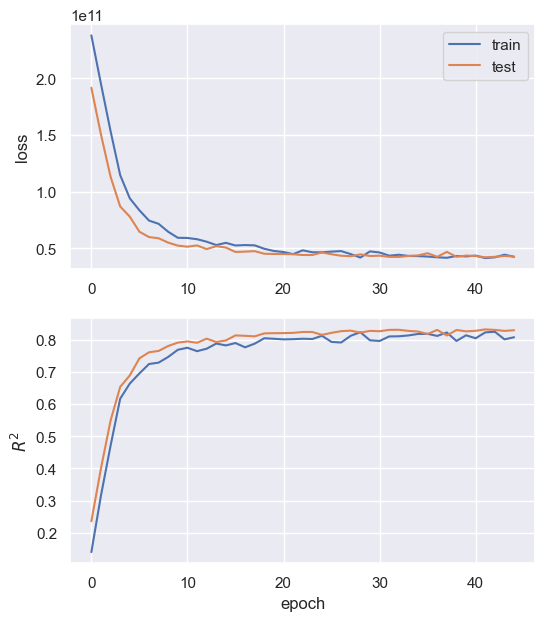

In [169]:
plot_train_test(train_losses[5:], train_r2s[5:], test_losses[5:], test_r2s[5:])

In [170]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader, DEVICE)

r2 = metrics.r2_score(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)  # тоже самое что и nn.MSELoss
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_true, y_pred)
mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
rmsle = np.sqrt(metrics.mean_squared_log_error(y_true, y_pred))
print(f"  R^2: {r2:.6f}")
print(f"  MSE: {mse:.6f}")
print(f" RMSE: {rmse:.6f}")
print(f"  MAE: {mae:.6f}")
print(f" MAPE: {mape:.6f}")
print(f"RMSLE: {rmsle:.6f}")

  R^2: 0.829138
  MSE: 42830147584.000000
 RMSE: 206954.453125
  MAE: 111268.257812
 MAPE: 0.254877
RMSLE: 0.311414


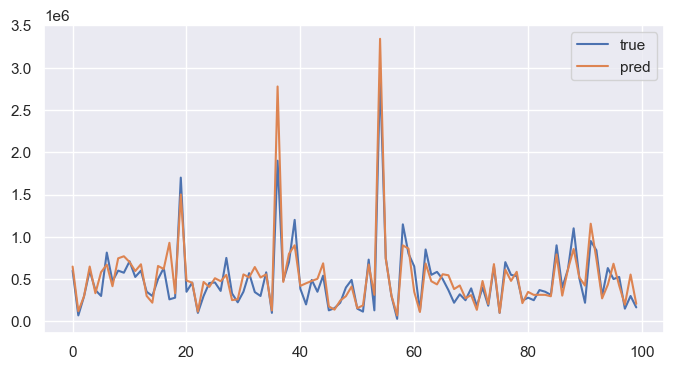

In [171]:
plot_y_true_y_pred(y_true[:100], y_pred[:100])

In [172]:
net.eval()
for i in torch.randperm(len(test_dataset))[:5]:
    x, y = test_dataset[i]
    print_y_true_y_pred(x, y, net, DEVICE)

Input:   tensor([ 0.3620, -0.2534,  1.0000,  1.0000,  1.0000,  0.0000, 13.0000, -0.4365,
        -0.4454])
Target:  475000.000000
Predict: 477467.250000

Input:   tensor([ 3.6199e-01, -6.3869e-02,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  8.8000e+01, -4.8667e-01,  3.6207e+00])
Target:  425000.000000
Predict: 621837.187500

Input:   tensor([-1.4383,  0.5048,  1.0000,  1.0000,  1.0000,  2.0000, 13.0000, -0.4051,
        -0.4454])
Target:  260000.000000
Predict: 179213.062500

Input:   tensor([ 1.1335, -0.3482,  3.0000,  1.0000,  0.0000,  0.0000, 41.0000,  1.0473,
        -0.4454])
Target:  1380000.000000
Predict: 909775.437500

Input:   tensor([-4.0102e+00, -6.3869e-02,  3.0000e+00,  1.0000e+00,  1.0000e+00,
         2.0000e+00,  1.1100e+02, -1.5972e+00, -1.4619e+00])
Target:  40000.000000
Predict: 80341.929688

